# Homework 2 - Geospatial Analysis
## EDS 296

In this assignment, you will perform some geospatial visualizations for a region of your choice.
The code constructed should be in Python, and follow a format similar to the tutorials we’ve
been working through in class. Use whatever section headings you like, so long as the tasks
below are included in the notebook!

1. Using the CMIP6 database hosted on Amazon Web Services, choose any two models you
like: use both their historical simulations and future projections from one of the four major
SSPs (ssp126, ssp245, ssp370, or ssp585). Provide a brief description of the models and
scenarios you chose to include.


2. Access information from your chosen models and scenario, for any climate variable you like;
however, note that three-dimensional data is generally larger and can be slower to load, so I
recommend either choosing a two-dimensional data field or reading in only the surface level
if you choose 3D information.

Some common choices of variables to analyze, and their CMIP names, include:
- Surface air temperature (tas)
- Precipitation (pr)
- Sea surface temperature (tos)

However, you can refer to the list of standard CMIP variables or search through the ESGF
website for others if you like!

In [132]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

In [133]:
# Load CMIP6 Catalog
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

In [134]:
# Specify search terms to query catalog 
# activity_id: which project do you want? CMIP = historical data, ScenarioMIP = future projections
activity_ids = ['ScenarioMIP', 'CMIP'] 

# source_id: Two models for this exercise 
source_id = ['MPI-ESM1-2-HR', 'BCC-CSM2-MR']

# experiment_id: what experimental configuration do you want? Here we want historical and the four main SSPs
experiment_ids = ['historical', 'ssp245']

table_id = "Omon"

member_id = ['r2i1p1f1', 'r2i1p1f3']

# variable_id: Sea Surface Temperature 
variable_id = 'tos' 

In [135]:
# Search through catalog, store results in "res" variable
res = catalog.search(activity_id=activity_ids, 
                     source_id=source_id,
                     experiment_id=experiment_ids,
                     table_id=table_id,
                     #member_id=member_id,
                     variable_id=variable_id
                    )

res = res.df
res

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,BCC,BCC-CSM2-MR,historical,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/BCC/BCC-CSM2-MR/hist...,NaN,20181031
1,CMIP,BCC,BCC-CSM2-MR,historical,r3i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/BCC/BCC-CSM2-MR/hist...,NaN,20181102
2,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/BCC/BCC-CSM2-MR/hist...,NaN,20181126
3,ScenarioMIP,BCC,BCC-CSM2-MR,ssp245,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/BCC/BCC-CSM2-...,NaN,20190319
4,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r5i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
5,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r4i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
6,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r10i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
7,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
8,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
9,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r3i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710


In [136]:
BCC = res[res["source_id"]=='BCC-CSM2-MR'].reset_index(drop=True)
esm1 = res[res["source_id"]=='MPI-ESM1-2-HR'].reset_index(drop=True)

In [137]:
for i in range(len(BCC)):
    print("member_id: ", BCC['member_id'][i])
    print("max year: ", 
          xr.open_zarr(BCC['zstore'][i], storage_options = {'anon':True}).time.max().dt.year.item())
    print("min year: ", 
          xr.open_zarr(BCC['zstore'][i], storage_options = {'anon':True}).time.min().dt.year.item())
    print()

member_id:  r2i1p1f1
max year:  2014
min year:  1850

member_id:  r3i1p1f1
max year:  2014
min year:  1850

member_id:  r1i1p1f1
max year:  2014
min year:  1850

member_id:  r1i1p1f1
max year:  2100
min year:  2015



In [138]:
BCC = BCC[BCC['member_id']=='r1i1p1f1']
BCC

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
2,CMIP,BCC,BCC-CSM2-MR,historical,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/BCC/BCC-CSM2-MR/hist...,NaN,20181126
3,ScenarioMIP,BCC,BCC-CSM2-MR,ssp245,r1i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/BCC/BCC-CSM2-...,NaN,20190319


In [139]:
hist_data_BCC = xr.open_zarr(BCC['zstore'][2], storage_options = {'anon':True})
proj_data_BCC = xr.open_zarr(BCC['zstore'][3], storage_options = {'anon':True})


In [140]:
for i in range(len(esm1)):
    print("member_id: ", esm1['member_id'][i])
    print("max year: ", 
          xr.open_zarr(esm1['zstore'][i], storage_options = {'anon':True}).time.max().dt.year.item())
    print("min year: ", 
          xr.open_zarr(esm1['zstore'][i], storage_options = {'anon':True}).time.min().dt.year.item())
    print()

member_id:  r5i1p1f1
max year:  2014
min year:  1850

member_id:  r4i1p1f1
max year:  2014
min year:  1850

member_id:  r10i1p1f1
max year:  2014
min year:  1850

member_id:  r2i1p1f1
max year:  2014
min year:  1850

member_id:  r1i1p1f1
max year:  2014
min year:  1850

member_id:  r3i1p1f1
max year:  2014
min year:  1850

member_id:  r8i1p1f1
max year:  2014
min year:  1850

member_id:  r7i1p1f1
max year:  2014
min year:  1850

member_id:  r1i1p1f1
max year:  2100
min year:  2015

member_id:  r2i1p1f1
max year:  2100
min year:  2015

member_id:  r9i1p1f1
max year:  2014
min year:  1850

member_id:  r6i1p1f1
max year:  2014
min year:  1850



In [141]:
esm1 = esm1[esm1['member_id']=='r2i1p1f1']
esm1

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
3,CMIP,MPI-M,MPI-ESM1-2-HR,historical,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/...,NaN,20190710
9,ScenarioMIP,DKRZ,MPI-ESM1-2-HR,ssp245,r2i1p1f1,Omon,tos,gn,s3://cmip6-pds/CMIP6/ScenarioMIP/DKRZ/MPI-ESM1...,NaN,20190710


In [142]:
hist_data_esm1 = xr.open_zarr(esm1['zstore'][3], storage_options = {'anon':True})
proj_data_esm1 = xr.open_zarr(esm1['zstore'][9], storage_options = {'anon':True})


As a model developed in the Southern Hemisphere, ACCESS-ESM1-5 performs relatively well in the Indo-Pacific region, including ENSO dynamics and ocean-atmosphere interactions. 

BCC-CSM2-MR is a climate model well suited for more general large scale patterns and is known for capturing major ocean circulation patterns.

SSP245 represents a middle of the orad approach with climate protection measure being taken.

In [143]:
# Concatenate esm1 data
esm1_245 = xr.concat([hist_data_esm1, proj_data_esm1], dim = "member")
# Concatenate BCC data
BCC_245 = xr.concat([hist_data_BCC, proj_data_BCC], dim = 'member')

/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/opt/anaconda3/envs/eds296-stevenson/lib/python3.8/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[k

In [144]:
esm1_245

<xarray.Dataset>
Dimensions:             (i: 802, j: 404, time: 3012, member: 2, bnds: 2,
                         vertices: 4)
Coordinates:
  * i                   (i) int32 0 1 2 3 4 5 6 ... 795 796 797 798 799 800 801
  * j                   (j) int32 0 1 2 3 4 5 6 ... 397 398 399 400 401 402 403
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12...
    latitude            (j, i) float64 51.15 51.15 51.15 ... -78.67 -78.67
    longitude           (j, i) float64 83.1 83.06 83.01 ... 82.4 82.85 83.3
    time_bnds           (member, time, bnds) datetime64[ns] 1850-01-01 ... 21...
Dimensions without coordinates: member, bnds, vertices
Data variables:
    tos                 (member, time, j, i) float32 dask.array<chunksize=(1, 66, 404, 802), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 dask.array<chunksize=(1, 404, 802, 4), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 dask.array<chunksize=(1, 404, 802, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  18261.0
    cmor_version:           3.5.0
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    tracking_id:            hdl:21.14100/42e40a29-9340-408d-91f3-fbf960d81d2d...
    variable_id:            tos
    variant_label:          r2i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/42e40a29-9340-408d-91f3-fbf960d81d2d...
    version_id:             v20190710

In [145]:
BCC_245

<xarray.Dataset>
Dimensions:    (lat: 232, lon: 360, time: 3012, bnds: 2, member: 2)
Coordinates:
  * lat        (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
    lat_bnds   (lat, bnds) float64 -81.5 -81.0 -81.0 -80.0 ... 89.0 89.0 89.5
    latitude   (lat, lon) float32 -81.5 -81.5 -81.5 -81.5 ... 88.26 88.05 87.83
    lon_bnds   (lon, bnds) float64 0.0 1.0 1.0 2.0 ... 358.0 359.0 359.0 360.0
    longitude  (lat, lon) float32 0.5 1.5 2.5 3.5 ... 60.95 63.36 65.25 66.77
    time_bnds  (member, time, bnds) object 1850-01-01 00:00:00 ... 2101-01-01...
Dimensions without coordinates: bnds, member
Data variables:
    tos        (member, time, lat, lon) float32 dask.array<chunksize=(1, 120, 232, 360), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/45b48654-08fa-4dc2-b66e-3a8d6937c8c0
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/45b48654-08fa-4dc2-b66e-3a8d6937c8c0
    version_id:             v20181126

3. Choose a region that you’re interested in to analyze, anywhere in the world. This should be a
region that’s fairly large - think, the size of a large country or a sizable fraction of a
continent. As you did for HW1, describe in markdown text some aspects of the climate of
your region: what are the interesting features there, and how might you expect that climate
change would impact the area?

The Marae Moana was recently designated as a Marine Protected Area in 2017. Because it is in the South Pacific, their weather is influenced by big climate patterns like El Niño and La Niña, which can bring droughts or heavy rains depending on the year. Climate change could bring more intense storms, rising sea levels, and hotter ocean temperatures that threaten coral reefs and coastal communities. These changes could make life more challenging for people living there, especially with limited land and freshwater resources. This MPA was created not only for the protection of wildlife, but the people have a symbiotic relationship with the environment, which climate change can threaten.



In [146]:
# Marae Moana bbox
lat_min, lat_max = -23, -10
lon_min, lon_max = 360 - 161, 360 - 155  # 199, 205

In [147]:
# Define logical mask: True when lat/lon inside the valid ranges, False elsewhere
esm1_245_tos_mm_lat = (esm1_245.latitude >= lat_min) & (esm1_245.latitude <= lat_max)
esm1_245_tos_mm_lon = (esm1_245.longitude >= lon_min) & (esm1_245.longitude <= lon_max)

BCC_245_tos_mm_lat = (BCC_245.lat >= lat_min) & (BCC_245.lat <= lat_max)
BCC_245_tos_mm_lon = (BCC_245.lon >= lon_min) & (BCC_245.lon <= lon_max)

# Find poits where the mask value True, drop all other points
tos_esm1_mm = esm1_245.where(esm1_245_tos_mm_lat & esm1_245_tos_mm_lon, drop = True)
tos_BCC_mm = BCC_245.where(BCC_245_tos_mm_lat & BCC_245_tos_mm_lon, drop = True)

In [148]:
tos_esm1_mm

<xarray.Dataset>
Dimensions:             (member: 2, time: 3012, j: 33, i: 13, vertices: 4,
                         bnds: 2)
Coordinates:
  * i                   (i) int32 259 260 261 262 263 ... 267 268 269 270 271
  * j                   (j) int32 228 229 230 231 232 ... 256 257 258 259 260
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 2100-12...
    latitude            (j, i) float64 -10.18 -10.18 -10.18 ... -22.71 -22.71
    longitude           (j, i) float64 199.4 199.9 200.3 ... 203.9 204.4 204.8
    time_bnds           (member, time, bnds) datetime64[ns] 1850-01-01 ... 21...
Dimensions without coordinates: member, vertices, bnds
Data variables:
    tos                 (member, time, j, i) float32 dask.array<chunksize=(1, 66, 33, 13), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 dask.array<chunksize=(1, 33, 13, 4), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 dask.array<chunksize=(1, 33, 13, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  18261.0
    cmor_version:           3.5.0
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    tracking_id:            hdl:21.14100/42e40a29-9340-408d-91f3-fbf960d81d2d...
    variable_id:            tos
    variant_label:          r2i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/42e40a29-9340-408d-91f3-fbf960d81d2d...
    version_id:             v20190710

In [149]:
tos_BCC_mm

<xarray.Dataset>
Dimensions:    (member: 2, time: 3012, lat: 23, lon: 6, bnds: 2)
Coordinates:
  * lat        (lat) float64 -22.74 -21.86 -20.99 -20.16 ... -10.84 -10.5 -10.17
  * lon        (lon) float64 199.5 200.5 201.5 202.5 203.5 204.5
  * time       (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
    lat_bnds   (lat, bnds) float64 -23.2 -22.3 -22.3 ... -10.33 -10.33 -10.0
    latitude   (lat, lon) float32 -22.74 -22.74 -22.74 ... -10.17 -10.17 -10.17
    lon_bnds   (lon, bnds) float64 199.0 200.0 200.0 201.0 ... 204.0 204.0 205.0
    longitude  (lat, lon) float32 -160.5 -159.5 -158.5 ... -157.5 -156.5 -155.5
    time_bnds  (member, time, bnds) object 1850-01-01 00:00:00 ... 2101-01-01...
Dimensions without coordinates: member, bnds
Data variables:
    tos        (member, time, lat, lon) float32 dask.array<chunksize=(1, 120, 23, 6), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/45b48654-08fa-4dc2-b66e-3a8d6937c8c0
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/45b48654-08fa-4dc2-b66e-3a8d6937c8c0
    version_id:             v20181126



4. Choose two separate time periods, each 30-50 years in length, and describe briefly why you
chose these periods: then make some maps of the time average of your selected variable.

2017 was the year that the region was designated as a marine projected area. I chose 1967-2017 to represent this before MPA time, and 2017-2077 to see how it will be targeted by climate change in the future.


a. Map the average over each time period separately


In [150]:
tos_BCC_mm_hist_mask = (tos_BCC_mm.time.dt.year >= 1967) & (tos_BCC_mm.time.dt.year <= 2017)
tos_BCC_mm_proj_mask = (tos_BCC_mm.time.dt.year >= 2027) & (tos_BCC_mm.time.dt.year <= 2077)

tos_esm1_mm_hist_mask = (tos_esm1_mm.time.dt.year >= 1967) & (tos_esm1_mm.time.dt.year <= 2017)
tos_esm1_mm_proj_mask = (tos_esm1_mm.time.dt.year >= 2027) & (tos_esm1_mm.time.dt.year <= 2077)


In [151]:
# Get data for an earlier period
esm1_hist_mm = tos_esm1_mm.sel(time=tos_esm1_mm_hist_mask)
BCC_hist_mm = tos_BCC_mm.sel(time=tos_BCC_mm_hist_mask)

# Get data for a later period
esm1_proj_mm = tos_esm1_mm.sel(time=tos_esm1_mm_proj_mask)
# Get data for a later period (corrected)
BCC_proj_mm = tos_BCC_mm.sel(time=tos_BCC_mm_proj_mask)


In [152]:
esm1_proj_mm

<xarray.Dataset>
Dimensions:             (member: 2, time: 612, j: 33, i: 13, vertices: 4,
                         bnds: 2)
Coordinates:
  * i                   (i) int32 259 260 261 262 263 ... 267 268 269 270 271
  * j                   (j) int32 228 229 230 231 232 ... 256 257 258 259 260
  * time                (time) datetime64[ns] 2027-01-16T12:00:00 ... 2077-12...
    latitude            (j, i) float64 -10.18 -10.18 -10.18 ... -22.71 -22.71
    longitude           (j, i) float64 199.4 199.9 200.3 ... 203.9 204.4 204.8
    time_bnds           (member, time, bnds) datetime64[ns] NaT ... 2078-01-01
Dimensions without coordinates: member, vertices, bnds
Data variables:
    tos                 (member, time, j, i) float32 dask.array<chunksize=(1, 54, 33, 13), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 dask.array<chunksize=(1, 33, 13, 4), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 dask.array<chunksize=(1, 33, 13, 4), meta=np.ndarray>
Attributes: (12/50)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  18261.0
    cmor_version:           3.5.0
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    tracking_id:            hdl:21.14100/42e40a29-9340-408d-91f3-fbf960d81d2d...
    variable_id:            tos
    variant_label:          r2i1p1f1
    netcdf_tracking_ids:    hdl:21.14100/42e40a29-9340-408d-91f3-fbf960d81d2d...
    version_id:             v20190710

In [153]:
BCC_hist_mm

<xarray.Dataset>
Dimensions:    (member: 2, time: 612, lat: 23, lon: 6, bnds: 2)
Coordinates:
  * lat        (lat) float64 -22.74 -21.86 -20.99 -20.16 ... -10.84 -10.5 -10.17
  * lon        (lon) float64 199.5 200.5 201.5 202.5 203.5 204.5
  * time       (time) object 1967-01-16 12:00:00 ... 2017-12-16 12:00:00
    lat_bnds   (lat, bnds) float64 -23.2 -22.3 -22.3 ... -10.33 -10.33 -10.0
    latitude   (lat, lon) float32 -22.74 -22.74 -22.74 ... -10.17 -10.17 -10.17
    lon_bnds   (lon, bnds) float64 199.0 200.0 200.0 201.0 ... 204.0 204.0 205.0
    longitude  (lat, lon) float32 -160.5 -159.5 -158.5 ... -157.5 -156.5 -155.5
    time_bnds  (member, time, bnds) object 1967-01-01 00:00:00 ... 2018-01-01...
Dimensions without coordinates: member, bnds
Data variables:
    tos        (member, time, lat, lon) float32 dask.array<chunksize=(1, 36, 23, 6), meta=np.ndarray>
Attributes: (12/52)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          Standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  2289.0
    cmor_version:           3.3.2
    ...                     ...
    tracking_id:            hdl:21.14100/45b48654-08fa-4dc2-b66e-3a8d6937c8c0
    variable_id:            tos
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:    hdl:21.14100/45b48654-08fa-4dc2-b66e-3a8d6937c8c0
    version_id:             v20181126

In [ ]:
# Calculate the ensemble means
esm1_hist_mm_mean = esm1_hist_mm.mean(dim="time")
esm1_hist_mm_mean = esm1_hist_mm_mean.mean(dim="member")

esm1_proj_mm_mean = esm1_proj_mm.mean(dim="time")
esm1_proj_mm_mean = esm1_proj_mm_mean.mean(dim="member")

BCC_hist_mm_mean = BCC_hist_mm.mean(dim="time")
BCC_hist_mm_mean = BCC_hist_mm_mean.mean(dim="member")

BCC_proj_mm_mean = BCC_proj_mm.mean(dim="time")
BCC_proj_mm_mean = BCC_proj_mm_mean.mean(dim="member")

Text(0.5, 1.0, 'CESM2 BCC TOS (projected)')

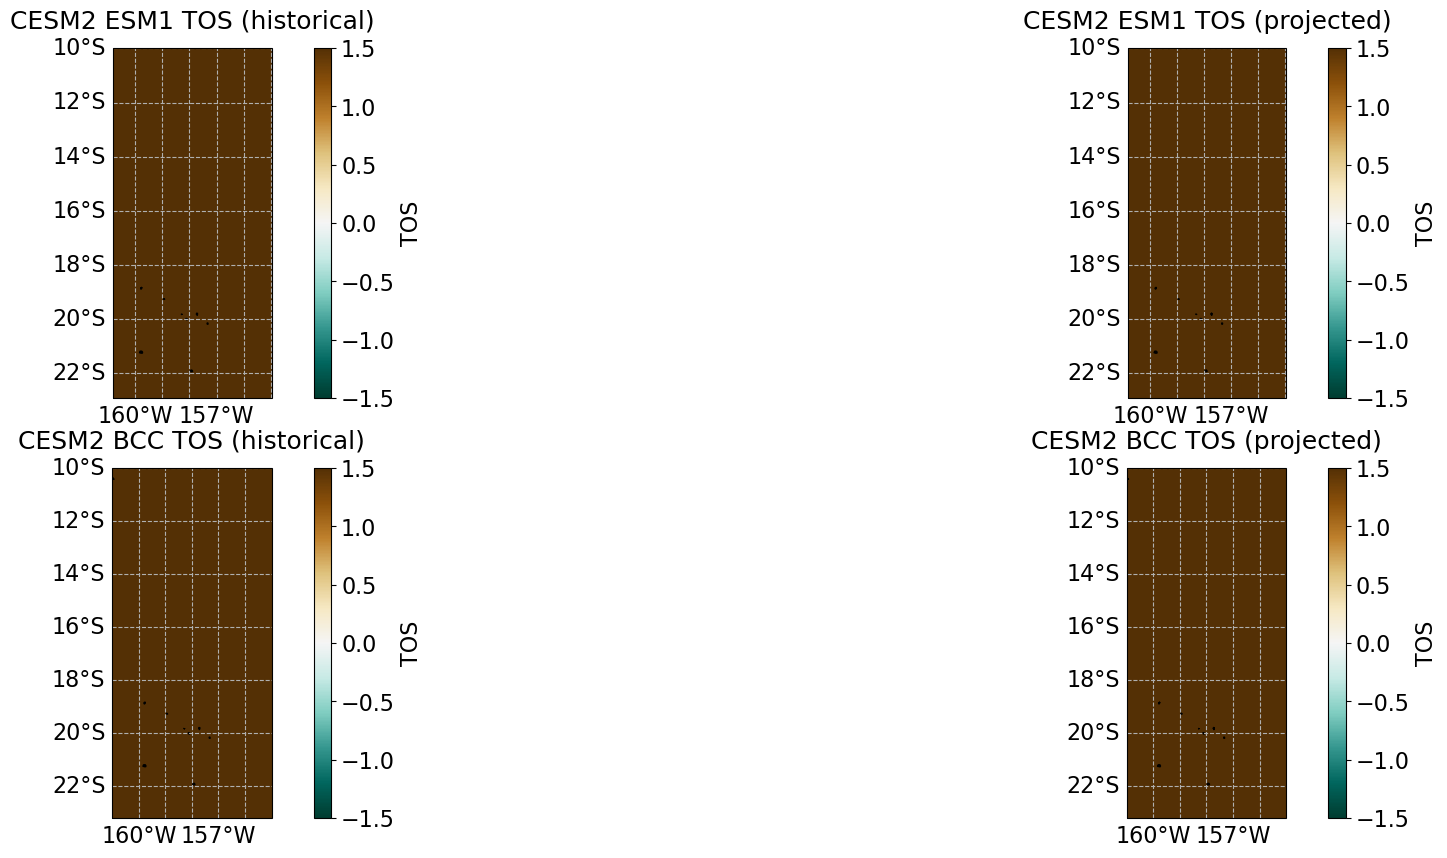

In [ ]:
# historical and projected trends of the two models
map = ccrs.PlateCarree()

# Make a figure with four subplots
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: ESM1 historical
plot1 = axes[0,0].pcolormesh(esm1_hist_mm_mean.longitude,
                           esm1_hist_mm_mean.latitude,
                           esm1_hist_mm_mean.tos,
                           transform=map, cmap="BrBG_r", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[0,0].add_feature(cfeature.COASTLINE)
axes[0,0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0,0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0,0], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0,0].set_title("CESM2 ESM1 TOS (historical)", fontsize=18)

# Subplot 2: ESM1 projected
plot2 = axes[0,1].pcolormesh(esm1_proj_mm_mean.longitude,
                           esm1_proj_mm_mean.latitude,
                           esm1_proj_mm_mean.tos,
                           transform=map, cmap="BrBG_r", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[0,1].add_feature(cfeature.COASTLINE)
axes[0,1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0,1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[0,1], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0,1].set_title("CESM2 ESM1 TOS (projected)", fontsize=18)

# Subplot 3: BCC Historical
plot3 = axes[1,0].pcolormesh(BCC_hist_mm_mean.longitude,
                           BCC_hist_mm_mean.latitude,
                           BCC_hist_mm_mean.tos,
                           transform=map, cmap="BrBG_r", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[1,0].add_feature(cfeature.COASTLINE)
axes[1,0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1,0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot3, ax=axes[1,0], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1,0].set_title("CESM2 BCC TOS (historical)", fontsize=18)

# Subplot 2: BCC
plot4 = axes[1,1].pcolormesh(BCC_proj_mm_mean.longitude,
                           BCC_proj_mm_mean.latitude,
                           BCC_proj_mm_mean.tos,
                           transform=map, cmap="BrBG_r", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[1,1].add_feature(cfeature.COASTLINE)
axes[1,1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1,1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot4, ax=axes[1,1], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1,1].set_title("CESM2 BCC TOS (projected)", fontsize=18)



b. Map the difference in the averages between the two time periods (note: make sure to label
which time period you subtracted from which!)

In [185]:
# Calculate the differences
esm1_diff_mm = esm1_proj_mm.mean(dim="time") - esm1_hist_mm.mean(dim="time")
BCC_diff_mm = BCC_proj_mm.mean(dim="time") - BCC_hist_mm.mean(dim="time")

In [186]:
esm1_diff_mm

<xarray.Dataset>
Dimensions:             (i: 13, j: 33, member: 2, vertices: 4)
Coordinates:
  * i                   (i) int32 259 260 261 262 263 ... 267 268 269 270 271
  * j                   (j) int32 228 229 230 231 232 ... 256 257 258 259 260
    latitude            (j, i) float64 -10.18 -10.18 -10.18 ... -22.71 -22.71
    longitude           (j, i) float64 199.4 199.9 200.3 ... 203.9 204.4 204.8
Dimensions without coordinates: member, vertices
Data variables:
    tos                 (member, j, i) float32 dask.array<chunksize=(1, 33, 13), meta=np.ndarray>
    vertices_latitude   (member, j, i, vertices) float64 dask.array<chunksize=(1, 33, 13, 4), meta=np.ndarray>
    vertices_longitude  (member, j, i, vertices) float64 dask.array<chunksize=(1, 33, 13, 4), meta=np.ndarray>

In [187]:
BCC_diff_mm

<xarray.Dataset>
Dimensions:    (lat: 23, lon: 6, bnds: 2, member: 2)
Coordinates:
  * lat        (lat) float64 -22.74 -21.86 -20.99 -20.16 ... -10.84 -10.5 -10.17
  * lon        (lon) float64 199.5 200.5 201.5 202.5 203.5 204.5
    lat_bnds   (lat, bnds) float64 -23.2 -22.3 -22.3 ... -10.33 -10.33 -10.0
    latitude   (lat, lon) float32 -22.74 -22.74 -22.74 ... -10.17 -10.17 -10.17
    lon_bnds   (lon, bnds) float64 199.0 200.0 200.0 201.0 ... 204.0 204.0 205.0
    longitude  (lat, lon) float32 -160.5 -159.5 -158.5 ... -157.5 -156.5 -155.5
Dimensions without coordinates: bnds, member
Data variables:
    tos        (member, lat, lon) float32 dask.array<chunksize=(1, 23, 6), meta=np.ndarray>

In [188]:
# Calculate the ensemble means
esm1_diff_mm_mean = esm1_diff_mm.mean(dim="member")
BCC_diff_mm_mean = BCC_diff_mm.mean(dim="member")



For both your sets of maps, display some relevant political/geographic boundaries overlaid
on the region: we saw some examples of how to do this using the Cartopy “feature” toolbox
in the mapping tutorials.




Text(0.5, 1.0, 'CESM2 BCC TOS (late-century - historical)')

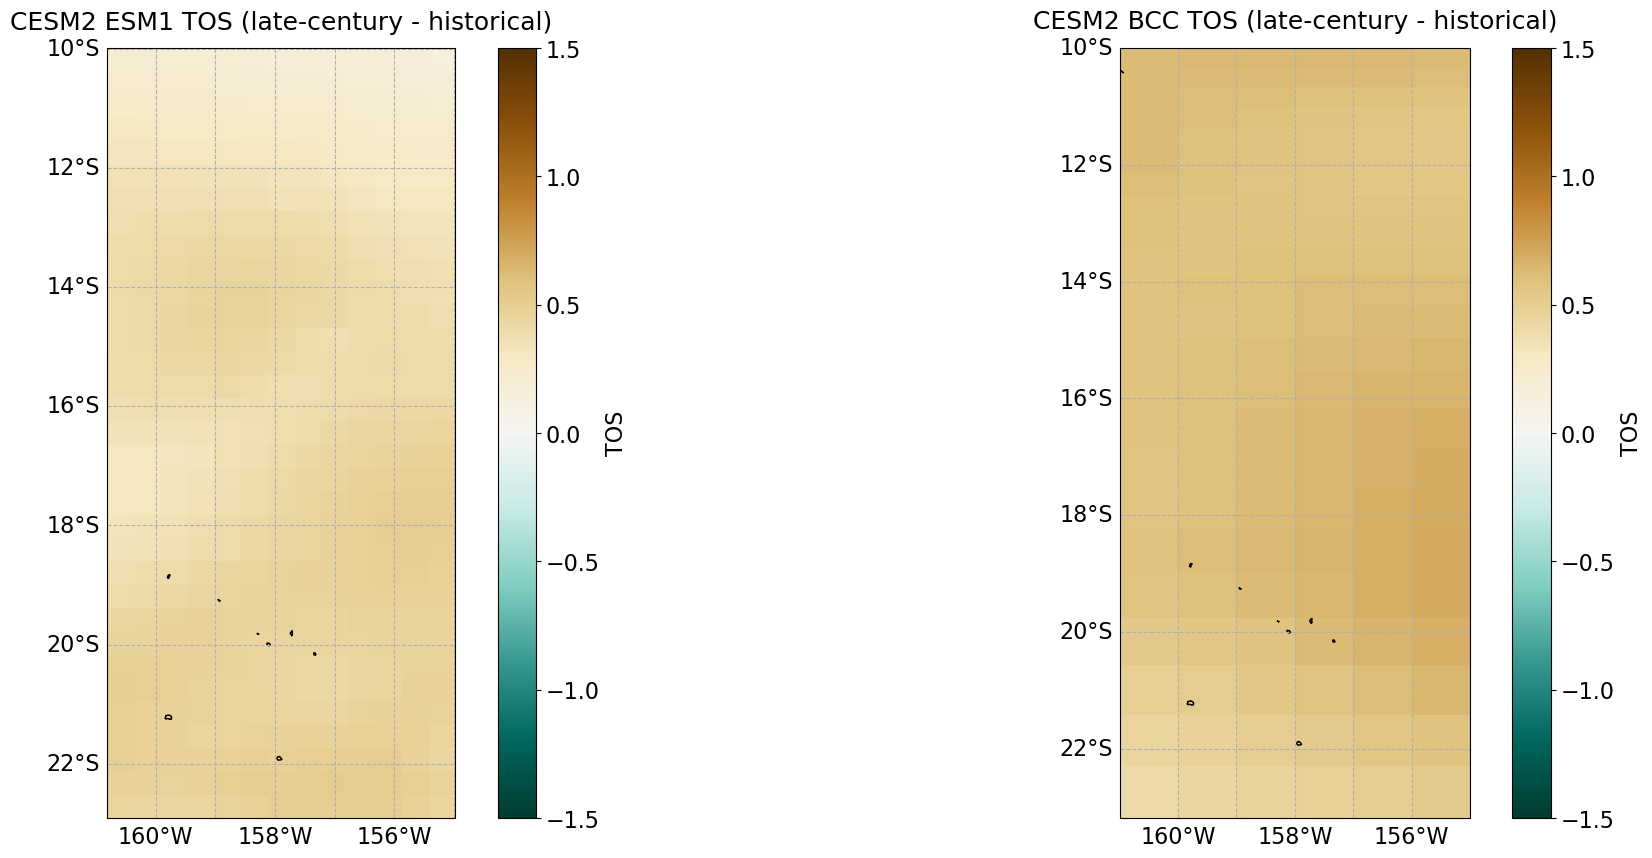

In [189]:
map = ccrs.PlateCarree()

# Make a figure with two subplots
fig, axes = plt.subplots(ncols=2, figsize=(24, 10), subplot_kw={"projection": map})

# Subplot 1: ESM1
plot1 = axes[0].pcolormesh(esm1_diff_mm_mean.longitude,
                           esm1_diff_mm_mean.latitude,
                           esm1_diff_mm_mean.tos,
                           transform=map, cmap="BrBG_r", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[0].add_feature(cfeature.COASTLINE)
axes[0].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[0].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot1, ax=axes[0], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[0].set_title("CESM2 ESM1 TOS (late-century - historical)", fontsize=18)

# Subplot 2: BCC
plot2 = axes[1].pcolormesh(BCC_diff_mm_mean.longitude,
                           BCC_diff_mm_mean.latitude,
                           BCC_diff_mm_mean.tos,
                           transform=map, cmap="BrBG_r", vmin=-1.5, vmax=1.5)

# Add coastlines, state borders, and gridlines
axes[1].add_feature(cfeature.COASTLINE)
axes[1].add_feature(cfeature.STATES, linestyle=":")
gl1 = axes[1].gridlines(draw_labels=True, linestyle="--")
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabel_style = {'size': 16}
gl1.ylabel_style = {'size': 16}

# Add colorbar
cbar1 = plt.colorbar(plot2, ax=axes[1], orientation='vertical', pad=0.05)
cbar1.set_label("TOS", fontsize=16)
cbar1.ax.tick_params(labelsize=16)

axes[1].set_title("CESM2 BCC TOS (late-century - historical)", fontsize=18)




5. Write 1-2 paragraphs in markdown text describing the results of your plot, and what you
think they might mean for humans or ecosystems located in your study region.
To hand in the assignment, upload a PDF version of the notebook to Canvas, and include a link
to the URL for the notebook on Github (so I can find the code).
This assignment should be completed individually, but you’re free to collaborate and discuss
with classmates as you work. Just make sure that what you hand in is unique!

The time series plot of regional mean sea surface temperatures (SST) near Marae Moana shows a consistent warming trend in both climate models (MPI-ESM1-2-HR and HadGEM3-GC31-LL) from the historical period into the SSP245 future projection. Across both models, SSTs increase by approximately 0.5°C to 1.5°C over the full timespan (1967-2077).

Coral reefs in Marae Moana are highly sensitive to thermal stress, as they already are living near to their thermal limits.. Increases in SST (as low as 1°C) can trigger coral bleaching events, leading to reduced reef resilience and biodiversity loss, which could be of concern in our area. Similarly, Warmer waters may disrupt the distribution and reproductive cycles of important fish species, which impact the already at risk human communities. These risks include tropical storms and sea level increase